# Example of working with radio interferometry data using `iLiSA`

**T. Carozzi**, *Onsala Space Observatory*

## Initializing
Start by importing the usual suspect python packages for analysis:

In [1]:
import numpy as np
import numpy.linalg as la
import mpl_toolkits as mpl
# Something wrong with path to mpl_toolkits, so hack it:
mpl.__path__ = ['/home/tobia/.local/lib/python3.8/site-packages/matplotlib-3.3.1-py3.8-linux-x86_64.egg/mpl_toolkits']
%matplotlib inline
import matplotlib.pyplot as plt

Then import the `iLiSA` specific packages:

In [2]:
from ilisa.observations.dataIO import *
from ilisa.calim.imaging import *
from ilisa.calim.calibration import apply_polgains

Choose a visibility datbase by specifying its path: 

In [3]:
cvcpath_acc = '/home/tobia/Documents/Data/LOFAR_COPY/sess_sid20201117T124331_SE607/scan_59170.53154/SE607_20201117_125349_rcu3_dur512_acc/'
#'/home/tobia/Documents/Data/LOFAR_COPY/proj31/sess_sid20200422T080002_SE607/scan_58961.33361/SE607_20200422_080850_rcu3_dur512_acc/'
cvcpath_xst = '/home/tobia/Documents/Data/LOFAR_COPY/xst/scan_59052.40191/20200722_093847_rcu4_sb457_int1_dur3_dir0.,1.5707963267948966,AZELGEO_xst'
cvcpath = cvcpath_acc

that is given as an argument to the covariance cube files class:

In [4]:
cvcds=CVCfiles(cvcpath)

Reading cvcfile: 20201117_125349_acc_512x192x192.dat


There are two acc files in this dataset. Select the first file's visibilities:

In [5]:
filenr=0
cvpol = cvcds.covcube_fb(filenr)

and select a subband channel:

In [6]:
sampnr=195 # 222, 299
vis=cvpol[:,:,sampnr,:,:]

and a polarization representation:

In [7]:
polrep='stokes'

For this selecton, the observational parameters are:

In [8]:
t=cvcds.samptimeset[filenr][sampnr]
freq=cvcds.freqset[filenr][sampnr]
print("Time: {} UT, Frequency: {} MHz, PolarRep: {}".format(t, freq/1e6, polrep))

Time: 2020-11-17 12:48:32 UT, Frequency: 38.0859375 MHz, PolarRep: stokes


## Looking at the visibilities

Plot the 4 linearly polarized components ((XX,XY),(YX,YY)) of this visibility sample

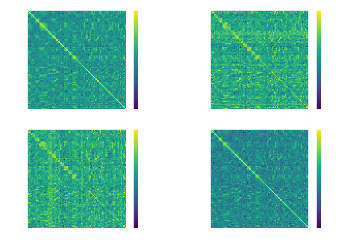

In [9]:
plt.subplot(221)
plt.imshow(20*np.log10(np.abs(vis[0,0,:,:])))
plt.colorbar()
plt.subplot(222)
plt.imshow(20*np.log10(np.abs(vis[0,1,:,:])))
plt.colorbar()
plt.subplot(223)
plt.imshow(20*np.log10(np.abs(vis[1,0,:,:])))
plt.colorbar()
plt.subplot(224)
plt.imshow(20*np.log10(np.abs(vis[1,1,:,:])))
plt.colorbar()

Define some directions, such as Zenith and Cas-A, and then calculate their corresponding UVW coordinates:

In [10]:
from ilisa.observations.directions import directionterm2tuple
dir_zen=directionterm2tuple('Z')
dir_casA = directionterm2tuple('Cas-A')
uvw_zen = calc_uvw(t, dir_zen, cvcds.stn_pos, cvcds.stn_antpos)
uvw_casA = calc_uvw(t, dir_casA, cvcds.stn_pos, cvcds.stn_antpos)

Plot the UV distribution of the antennas:

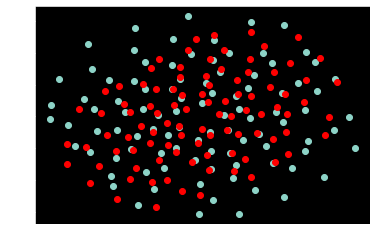

In [11]:
plt.scatter(uvw_zen[:,0],uvw_zen[:,1])
plt.scatter(uvw_casA[:,0],uvw_casA[:,1],c='r')

Image the visibility

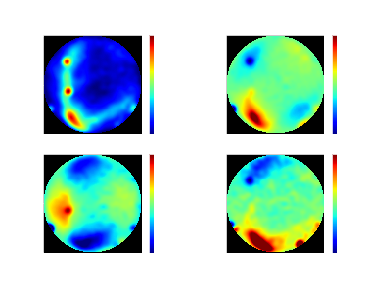

In [15]:
img, ll,mm, phaseref = cvc_image(cvcds, filenr, sampnr, polrep=polrep)
plotskyimage(ll,mm, img,polrep, t, freq, cvcds.scanrecinfo.stnid, cvcds.scanrecinfo.get_integration(), phaseref=phaseref)

Make a beamformed image and plot it

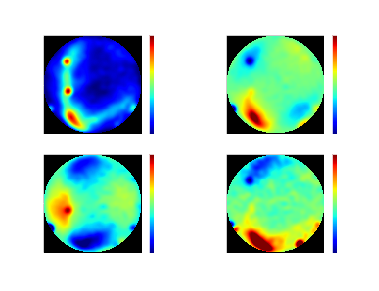

In [13]:
imgs_lin, ll, mm = beamformed_image(vis, uvw_zen.T, freq, use_autocorr=False, polrep=polrep, fluxperbeam=True)
plotskyimage(ll, mm, imgs_lin, polrep, t, freq, cvcds.scanrecinfo.stnid, cvcds.scanrecinfo.get_integration(), phaseref=dir_zen)

Re-center image towards Cassiopeia-A:

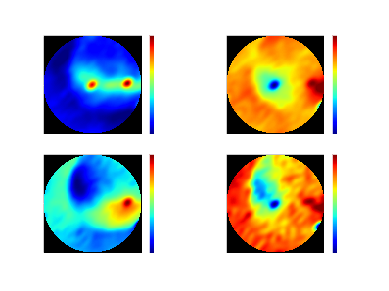

In [14]:
vis_pu = phaseref_xstpol(vis, uvw_casA, freq)
imgs_pu, ll, mm = beamformed_image(vis_pu, uvw_casA.T, freq, use_autocorr=False, polrep=polrep, fluxperbeam=True)
plotskyimage(ll,mm,imgs_pu,polrep, t, freq, cvcds.scanrecinfo.stnid, cvcds.scanrecinfo.get_integration(),phaseref=dir_casA)